In [1]:
import torch
from utils import save_checkpoint, load_checkpoint, save_some_examples #该文件是保存模型所用
import torch.nn as nn
import torch.optim as optim
import config
import torchvision
from dataset import MapDataset
from generator import Generator
from discriminator import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### 1： 首先我们需要加载数据集，该数据集是数据增强处理过的数据集

In [2]:
root = "data/maps/train"
train_dataset = MapDataset(root)
train_loader = DataLoader(train_dataset,batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)

In [3]:
real_batch = next(iter(train_loader))
print(real_batch[1].shape)

torch.Size([16, 3, 256, 256])


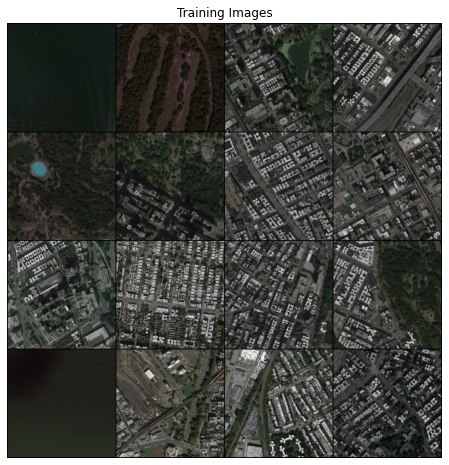

In [4]:
# 对input_image做的可视化
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(config.DEVICE)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

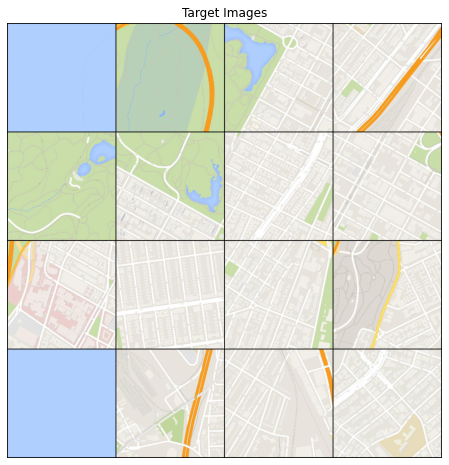

In [5]:
# 对于target_image做可视化，与上图应该是一一对应的 只不过上图是做过数据增强的，比如镜像和抖动
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Target Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(config.DEVICE)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# 验证集，该部分用来观察训练结果
val_dataset = MapDataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

### 2：在vram不足的情况下，可以通过amp的方式提升效率，用该方法时需要提前声明好对象

该情况只能在有GPU的情况下使用，使用函数为torch.cuda.amp

In [7]:
# 分别为生成器与判别器定义对象，需要在训练最开始之前使用amp.GradScaler实例化一个GradScaler对象
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

### 3： 初始化各个模型

In [8]:
# 判别器和生成器的模型
disc = Discriminator(in_channels=3).to(config.DEVICE)
gen = Generator(in_channels=3, features=64).to(config.DEVICE)

# 优化器的模型
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))

# 损失函数的模型
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

In [9]:
def train_fn(disc,gen,loader,opt_disc,opt_gen,l1,bce,g_scaler,d_scaler):
    loop = tqdm(loader, leave=True) #该方法用来记录每个epoch的进程
    
    for idx, (x,y) in enumerate(loop):
        x = x.to(config.DEVICE) # x为输入图片
        y = y.to(config.DEVICE) # y为目标图片
        
        # 先训练判别器
        # autocast()只负责正向传播
        with torch.cuda.amp.autocast():
            
            y_fake = gen(x)
            D_fake = disc(x, y_fake.detach()) # 该步骤是固定住G不动，这个在GAN里面很重要！
            D_real = disc(x, y)
            
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        
        # 训练生成器，需要主要生成器的损失函数是需要引入L1正则化的
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad() # 为什么上面是对判别器模型做zerograd，这里是对优化器做zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [10]:
if config.LOAD_MODEL:
    load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,)
    load_checkpoint(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE,)

In [ ]:
for epoch in range(config.NUM_EPOCHS):
    
    # 实验设定训练50次看结果
    train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

    # 存储模型
    if config.SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)
    
    # 观看训练结果
    save_some_examples(gen, val_loader, epoch, folder="evaluation")